In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

In [25]:
df = pd.read_csv('creditcard.csv')

###**Data Exploration:**###

In [26]:
print("First 5 rows of the dataset:\n", df.head()) #first few rows
print("\nShape of the dataset:", df.shape) #shape of the dataset
print("\nDataset Info:\n", df.info()) #data types
print("\nDescriptive statistics:\n", df.describe()) #descriptive statistics
print("\nMissing values per column:\n", df.isnull().sum()) #missing values
print("\nClass distribution:\n", df['Class'].value_counts()) #checking imbalance: 0:legitamate; 1: fraud

First 5 rows of the dataset:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

  

### **Feature Scaling**

In [27]:
# feature scaling
X = df.drop('Class', axis=1)
y = df['Class']
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

print("\n'Amount' and 'Time' columns scaled successfully.")


'Amount' and 'Time' columns scaled successfully.


###**Anomaly Detection (Isolation Forest)**

In [28]:
iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto') #Contamination set to auto

# Fit the model
iso_forest.fit(X)
anomaly_scores = iso_forest.decision_function(X)
anomalies = iso_forest.predict(X)

# add anomaly scores and anomalies in df
df['anomaly_score'] = anomaly_scores
df['anomaly'] = anomalies

# remove anomalies
df = df[df['anomaly'] == 1]
X = df.drop(['Class', 'anomaly_score', 'anomaly'], axis=1)
y = df['Class']

print("\nAnomalies detected and removed from the dataset")


Anomalies detected and removed from the dataset


###**Data Visualization**

<ipython-input-29-0fbe5341ddfb>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette = 'viridis')


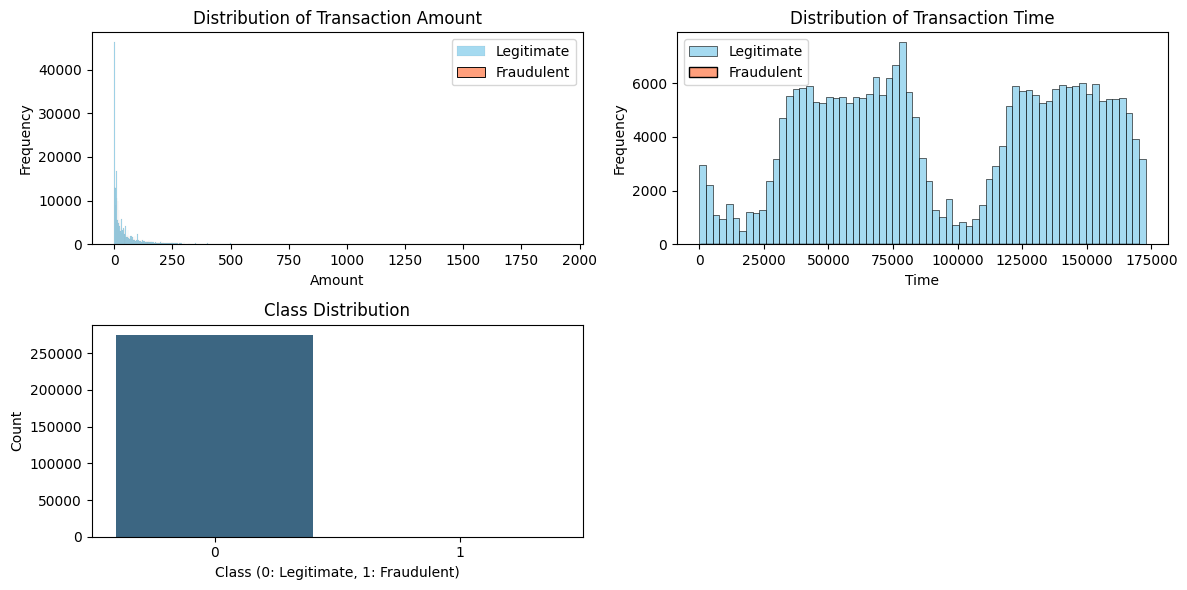

In [29]:
plt.figure(figsize=(12, 6))

# Histogram of 'Amount' for each class
plt.subplot(2, 2, 1)
sns.histplot(df[df['Class'] == 0]['Amount'], label='Legitimate', color = 'skyblue')
sns.histplot(df[df['Class'] == 1]['Amount'], label='Fraudulent', color = 'coral')
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()

# Histogram of 'Time' for each class
plt.subplot(2, 2, 2)
sns.histplot(df[df['Class'] == 0]['Time'], label='Legitimate', color = 'skyblue')
sns.histplot(df[df['Class'] == 1]['Time'], label='Fraudulent', color = 'coral')
plt.title('Distribution of Transaction Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()

# Bar plot for class balance
plt.subplot(2, 2, 3)
sns.countplot(x='Class', data=df, palette = 'viridis')
plt.title('Class Distribution')
plt.xlabel('Class (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

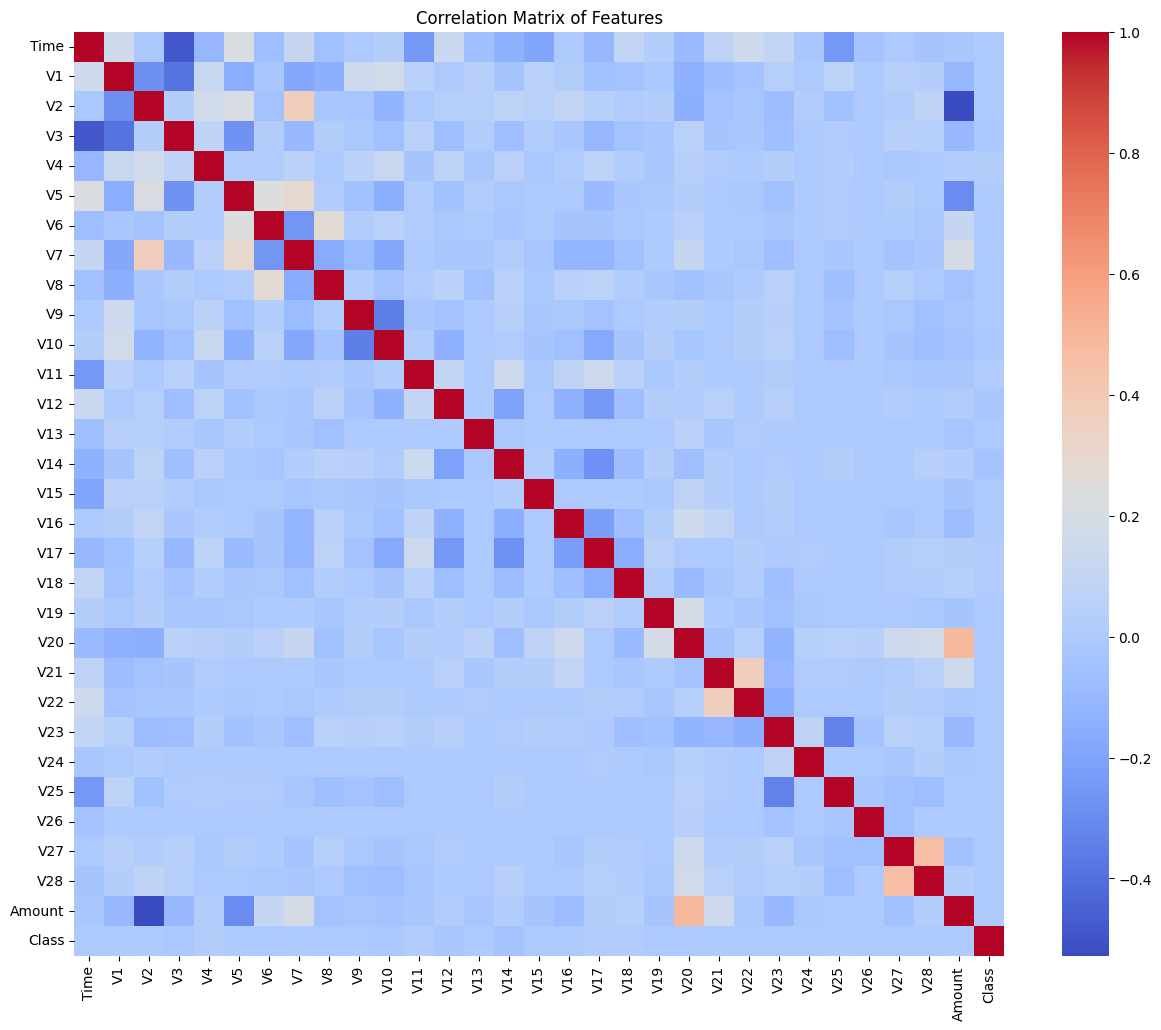

In [30]:
# correlation matrix
correlation_matrix = df.drop(['anomaly','anomaly_score'],axis=1).corr()

# correlation matrix using a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

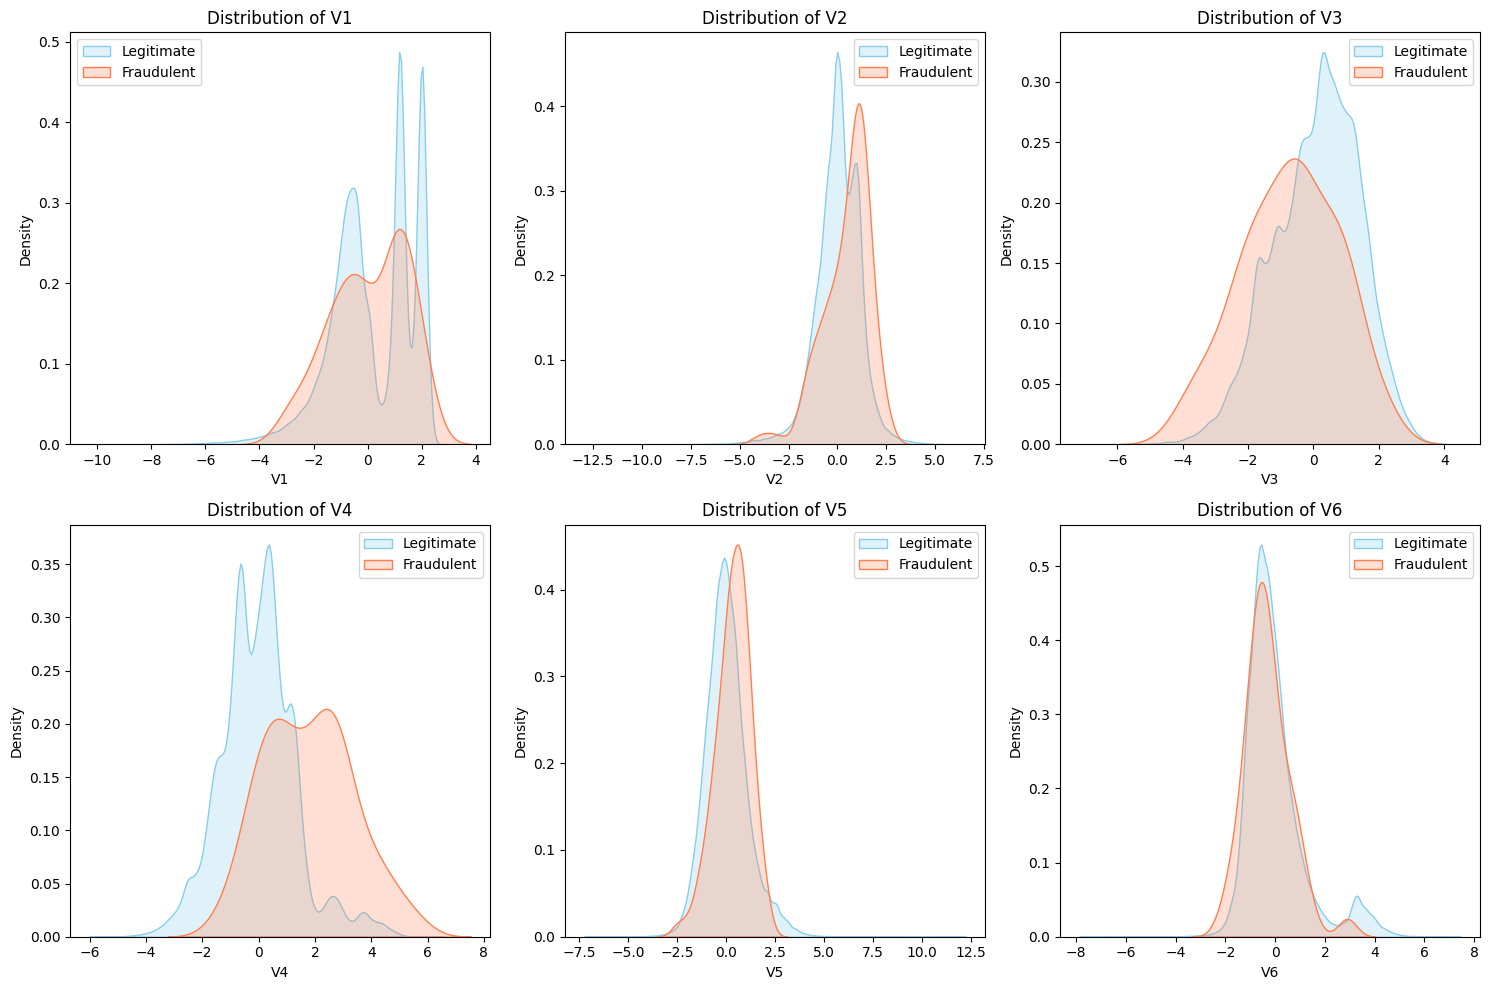

In [31]:
selected_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# grid of subplots for feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(df[df['Class'] == 0][feature], label='Legitimate', fill = True, color = 'skyblue')
    sns.kdeplot(df[df['Class'] == 1][feature], label='Fraudulent', fill = True, color = 'coral')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

### **Splitting data**

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Data split into training and test sets.")

Data split into training and test sets.


###**Random Forest Classifier**

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train
rf_model.fit(X_train, y_train)

# predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


# Evaluate
auc_roc_rf = roc_auc_score(y_test, y_prob_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("\nRandom Forest Model Performance:")
print(f"AUC-ROC: {auc_roc_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")


Random Forest Model Performance:
AUC-ROC: 0.6791
Precision: 1.0000
Recall: 0.0370
F1 Score: 0.0714


### **XGBoost Classifier**

In [34]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum())
# Train
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
auc_roc_xgb = roc_auc_score(y_test, y_prob_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("\nXGBoost Model Performance:")
print(f"AUC-ROC: {auc_roc_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



XGBoost Model Performance:
AUC-ROC: 0.8680
Precision: 0.6667
Recall: 0.2222
F1 Score: 0.3333


In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

###**PySpark**

In [36]:
# Initialize Spark session
spark = SparkSession.builder.appName("CreditCardFraud").getOrCreate()

# Load data as a Spark DataFrame
spark_df = spark.createDataFrame(df)

print("PySpark session initialized and data loaded successfully.")

PySpark session initialized and data loaded successfully.


In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# assemble columns into a vector
feature_cols = X.columns.tolist()

# define VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# apply VectorAssembler
assembled_df = assembler.transform(spark_df)

# define StandardScaler
scaler_pyspark = StandardScaler(inputCol="features", outputCol="scaled_features")

# fit StandardScaler on data
scaler_model = scaler_pyspark.fit(assembled_df)

# apply StandardScaler
scaled_df = scaler_model.transform(assembled_df)

# select necessary columns
pyspark_data = scaled_df.select("scaled_features", "Class")

print("Data Transformation Done")

Data Transformation Done


In [38]:
# Split the data into training and test sets
train_data, test_data = pyspark_data.randomSplit([0.7, 0.3], seed=42)

# Random Forest Model
rf_spark = SparkRandomForestClassifier(featuresCol="scaled_features", labelCol="Class", seed=42, numTrees=100)
rf_model_spark = rf_spark.fit(train_data)

# Predictions and Evaluation
predictions_rf = rf_model_spark.transform(test_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class")
auc_roc_rf_spark = evaluator.evaluate(predictions_rf)

print(f"PySpark Random Forest AUC-ROC: {auc_roc_rf_spark:.4f}")

PySpark Random Forest AUC-ROC: 0.8390


###**Statistical Analysis**

In [34]:
from scipy.stats import ttest_ind

features_to_test = ['Amount', 'Time', 'V1', 'V2', 'V3', 'V4']

# hypothesis testing for each feature
for feature in features_to_test:
    fraud_data = df[df['Class'] == 1][feature]
    non_fraud_data = df[df['Class'] == 0][feature]

    #t-test
    t_stat, p_val = ttest_ind(fraud_data, non_fraud_data)

    print(f"\nFeature: {feature}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.4f}")

    # Interpret p-value
    alpha = 0.05
    if p_val < alpha:
      print(f"The difference in means between fraud and non-fraud transactions for {feature} is statistically significant.")
    else:
      print(f"There is no statistically significant difference in means between fraud and non-fraud transactions for {feature}.")


Feature: Amount
T-statistic: 4.0722
P-value: 0.0000
The difference in means between fraud and non-fraud transactions for Amount is statistically significant.

Feature: Time
T-statistic: -1.0841
P-value: 0.2783
There is no statistically significant difference in means between fraud and non-fraud transactions for Time.

Feature: V1
T-statistic: -0.8425
P-value: 0.3995
There is no statistically significant difference in means between fraud and non-fraud transactions for V1.

Feature: V2
T-statistic: 3.7034
P-value: 0.0002
The difference in means between fraud and non-fraud transactions for V2 is statistically significant.

Feature: V3
T-statistic: -5.8365
P-value: 0.0000
The difference in means between fraud and non-fraud transactions for V3 is statistically significant.

Feature: V4
T-statistic: 12.6000
P-value: 0.0000
The difference in means between fraud and non-fraud transactions for V4 is statistically significant.


In [43]:
from scipy.stats import chi2_contingency

df['Amount_Bins'] = pd.cut(df['Amount'], bins=5, labels=False)
df['Amount_Bins'] = df['Amount_Bins'].astype('category')

contingency_table = pd.crosstab(df['Amount_Bins'], df['Class'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Squared Test for Amount Bins and Class:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

alpha = 0.05
if p < alpha:
    print("There is a statistically significant association between Amount Bins and Class.")
else:
    print("There is no statistically significant association between Amount Bins and Class.")

# Remove the temporary column
df.drop('Amount_Bins', axis=1, inplace=True)

Chi-Squared Test for Amount Bins and Class:
Chi2 Statistic: 32.7325
P-value: 0.0000
There is a statistically significant association between Amount Bins and Class.


In [44]:
from scipy.stats import f_oneway

bins = pd.cut(df['Amount'], bins=5, labels=False)
df['Amount_Group'] = bins

amount_groups_fraud = [df[(df['Class'] == 1) & (df['Amount_Group'] == i)]['Amount'] for i in range(5)]
amount_groups_non_fraud = [df[(df['Class'] == 0) & (df['Amount_Group'] == i)]['Amount'] for i in range(5)]

for i in range(5):
    if len(amount_groups_fraud [i]) > 1 and len(amount_groups_non_fraud [i]) > 1: # Ensure at least two samples in each group
        f_statistic, p_value = f_oneway(amount_groups_fraud [i], amount_groups_non_fraud [i])
        print(f"\nANOVA for Amount Group {i}:")
        print(f"F-statistic: {f_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")
        alpha = 0.05
        if p_value < alpha:
            print("There is a statistically significant difference in Amount between fraud and non-fraud in this group.")
        else:
            print("There is no statistically significant difference in Amount between fraud and non-fraud in this group.")
    else:
        print(f"\nNot enough data to perform ANOVA for Amount Group {i}.")

#remove the temporary column
df.drop('Amount_Group', axis=1, inplace=True)


ANOVA for Amount Group 0:
F-statistic: 1.1673
P-value: 0.2800
There is no statistically significant difference in Amount between fraud and non-fraud in this group.

ANOVA for Amount Group 1:
F-statistic: 2.9575
P-value: 0.0855
There is no statistically significant difference in Amount between fraud and non-fraud in this group.

ANOVA for Amount Group 2:
F-statistic: 0.0957
P-value: 0.7571
There is no statistically significant difference in Amount between fraud and non-fraud in this group.

Not enough data to perform ANOVA for Amount Group 3.

Not enough data to perform ANOVA for Amount Group 4.


In [42]:
from scipy.stats import spearmanr, kendalltau

# Spearman Correlation
spearman_corr_amount, spearman_p_amount = spearmanr(df['Amount'], df['Class'])
print(f"\nSpearman Correlation (Amount vs. Class): {spearman_corr_amount:.4f}, P-value: {spearman_p_amount:.4f}")

spearman_corr_time, spearman_p_time = spearmanr(df['Time'], df['Class'])
print(f"Spearman Correlation (Time vs. Class): {spearman_corr_time:.4f}, P-value: {spearman_p_time:.4f}")

# Kendall Tau Correlation
kendall_corr_amount, kendall_p_amount = kendalltau(df['Amount'], df['Class'])
print(f"\nKendall Tau Correlation (Amount vs. Class): {kendall_corr_amount:.4f}, P-value: {kendall_p_amount:.4f}")

kendall_corr_time, kendall_p_time = kendalltau(df['Time'], df['Class'])
print(f"Kendall Tau Correlation (Time vs. Class): {kendall_corr_time:.4f}, P-value: {kendall_p_time:.4f}")


Spearman Correlation (Amount vs. Class): -0.0044, P-value: 0.0207
Spearman Correlation (Time vs. Class): -0.0017, P-value: 0.3719

Kendall Tau Correlation (Amount vs. Class): -0.0036, P-value: 0.0207
Kendall Tau Correlation (Time vs. Class): -0.0014, P-value: 0.3719


In [44]:
from scipy.stats import ks_2samp

features_to_compare = ['Amount', 'Time', 'V1', 'V2']

for feature in features_to_compare:
    fraud_data = df.loc[(df['Class'] == 1), feature]
    non_fraud_data = df.loc[(df['Class'] == 0), feature]

    ks_statistic, p_value = ks_2samp(fraud_data, non_fraud_data)

    print(f"\nKolmogorov-Smirnov Test for {feature}:")
    print(f"KS Statistic: {ks_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print(f"The distribution of {feature} is significantly different between fraud and non-fraud transactions.")
    else:
        print(f"There is no significant difference in the distribution of {feature} between fraud and non-fraud transactions.")


Kolmogorov-Smirnov Test for Amount:
KS Statistic: 0.2395
P-value: 0.0001
The distribution of Amount is significantly different between fraud and non-fraud transactions.

Kolmogorov-Smirnov Test for Time:
KS Statistic: 0.1139
P-value: 0.1840
There is no significant difference in the distribution of Time between fraud and non-fraud transactions.

Kolmogorov-Smirnov Test for V1:
KS Statistic: 0.1307
P-value: 0.0872
There is no significant difference in the distribution of V1 between fraud and non-fraud transactions.

Kolmogorov-Smirnov Test for V2:
KS Statistic: 0.2978
P-value: 0.0000
The distribution of V2 is significantly different between fraud and non-fraud transactions.
